## Imports & Helpers

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../../')

from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH)
TILES_PER_MM2 = 0.256**-2

MIN_TIL_COUNT = 10
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
pd.read_csv('/home/jupyter/checkmate-histo/20210910_cm025_til_grade_sweep_inspection_samples_450_THOMAS_TEMPLATE_filled.csv')

Unnamed: 0  rel_idx TIL/noTIL/Too difficult Extent of TIL
0             0        0                  no til           NaN
1             1        1                     til           few
2             2        2                hard/til      moderate
3             3        3                     til      moderate
4             4        4                     til      moderate
..          ...      ...                     ...           ...
445         445      445                  no til           NaN
446         446      446                     til      moderate
447         447      447                     til           few
448         448      448                     til           few
449         449      449                     til           few

[450 rows x 4 columns]

In [15]:
tilewise = pd.read_csv('../rerun_tilewise_grade_til_annotations.csv')

In [16]:
tilewise_anno = tilewise.set_index(['unique_id','x','y'])

In [18]:
ext_samples = pd.read_csv('/home/jupyter/checkmate-histo/grade_til_inspection_450/20210910_cm025_til_grade_sweep_inspection_samples_450.csv')
t_samples = pd.read_csv('/home/jupyter/checkmate-histo/20210910_cm025_til_grade_sweep_inspection_samples_450_THOMAS_TEMPLATE_filled.csv', index_col=1).iloc[:,1:]
t_samples = ext_samples.set_index('rel_idx').join(t_samples)

t_til_mapper = {
    'high':'high', 'none':'n/a', 'moderate/high':'moderate', 'few':'low', 'moderate':'moderate', 1:'low', 'moderate ':'moderate',
    'lot':'high', 'very few':'low'
}

t_samples['yes_til_thomas'] = t_samples['TIL/noTIL/Too difficult'] == 'til'
t_samples['til_extent_thomas'] = t_samples['Extent of TIL'].map(t_til_mapper)
t_samples['Extent of TIL'] = t_samples['Extent of TIL'].fillna('n/a')
t_samples['til_extent_thomas'] = t_samples['til_extent_thomas'].fillna('n/a')

t_samples['mod_high_infiltration_thomas'] = (t_samples['til_extent_thomas'] == 'moderate') | (t_samples['til_extent_thomas'] == 'high')
t_samples['high_infiltration_thomas'] = t_samples['til_extent_thomas'] == 'high'

t_samples = t_samples.reset_index().set_index(['unique_id','x','y']).join(tilewise_anno[['smoothed_prob_tumor','smoothed_prob_g4_not_g2','til_counts']])

In [21]:
t_samples.til_extent_thomas.value_counts()

n/a         166
low         159
moderate     89
high         36
Name: til_extent_thomas, dtype: int64

In [ ]:
crit = ~(t_samples['yes_til_thomas'] & )
t_samples.loc[crit]

In [37]:
t_samples[['yes_til_thomas','til_extent_thomas']].value_counts()

yes_til_thomas  til_extent_thomas
False           n/a                  166
True            low                  159
                moderate              88
                high                  36
False           moderate               1
dtype: int64

In [39]:
(~t_samples['yes_til_thomas'] & (t_samples['til_extent_thomas'] == 'moderate')).sum()

1

In [40]:
t_samples = t_samples.loc[~(~t_samples['yes_til_thomas'] & (t_samples['til_extent_thomas'] == 'moderate'))]

In [41]:
t_samples[['yes_til_thomas','til_extent_thomas']].value_counts()

yes_til_thomas  til_extent_thomas
False           n/a                  166
True            low                  159
                moderate              88
                high                  36
dtype: int64

In [46]:
n_samples = 5
samples = t_samples.groupby(['yes_til_thomas','til_extent_thomas']).apply(lambda x: x.sample(min(len(x),n_samples)))

In [72]:
# set_rc(12,5)
# for (til_binary, til_extent), subdf in samples.reset_index(drop=True).groupby(['yes_til_thomas','til_extent_thomas']):
#     print(til_binary, til_extent, subdf.shape)
#     fig,axes = plt.subplots(1,n_samples)
    
#     for rel_idx, (row_idx, row) in enumerate(subdf.iterrows()):
#         img = cv2.cvtColor(cv2.imread(row['full_path']), cv2.COLOR_BGR2RGB)
#         axes[rel_idx].imshow(img)
#         axes[rel_idx].axis('off')
        
#     title = f'Infiltration Extent = {til_extent.title()}' if til_binary else "Non-Infiltrated"
#     plt.suptitle(title, y=.75)
#     plt.savefig(f'./sweep_outputs/tile_level_anno_example_{title}.png', bbox_inches='tight')
#     plt.savefig(f'./sweep_outputs/tile_level_anno_example_{title}.pdf', bbox_inches='tight')
#     plt.show()

False n/a (5, 13)


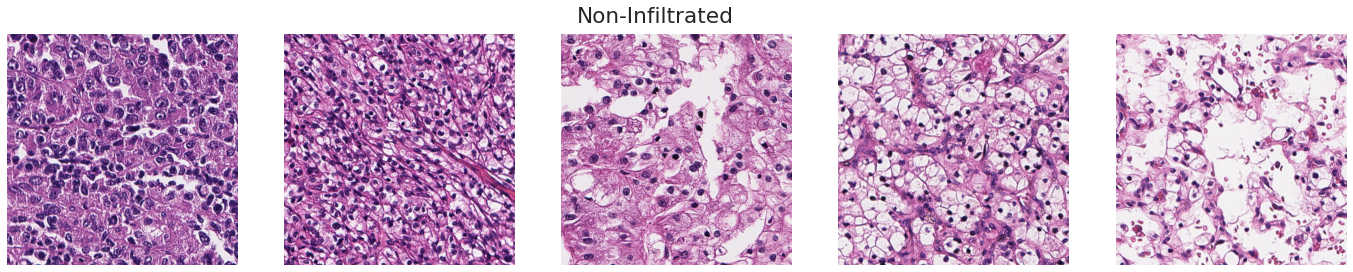

True high (5, 13)


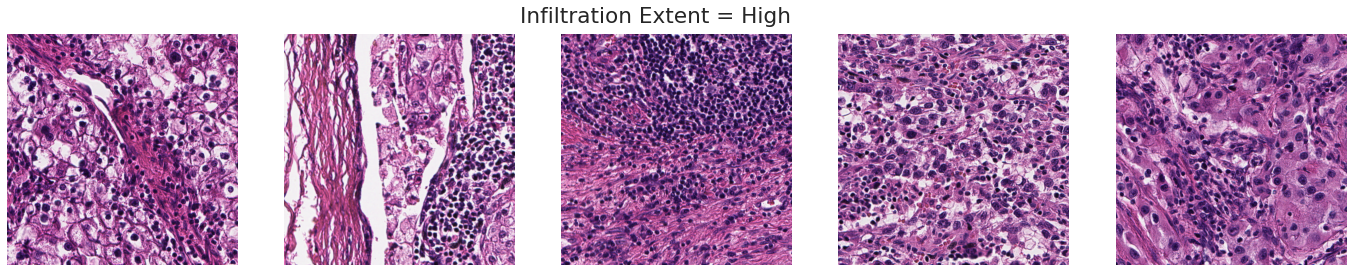

True low (5, 13)


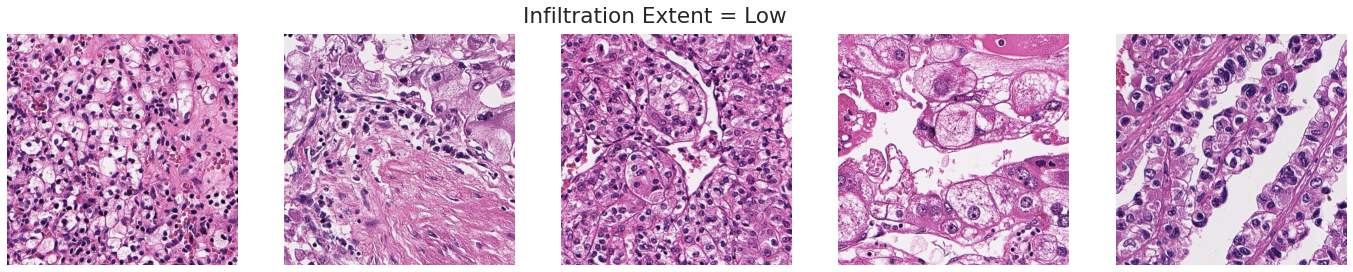

True moderate (5, 13)


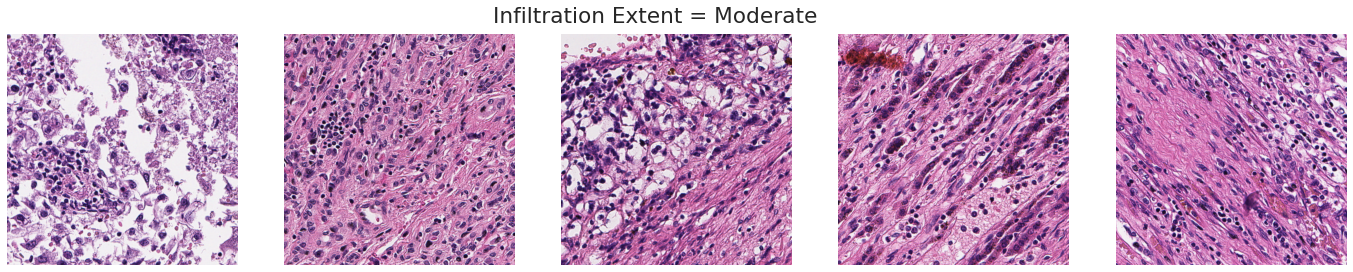

In [73]:
set_rc(24,8, 1.5)
for (til_binary, til_extent), subdf in samples.reset_index(drop=True).groupby(['yes_til_thomas','til_extent_thomas']):
    print(til_binary, til_extent, subdf.shape)
    fig,axes = plt.subplots(1,n_samples)
    
    for rel_idx, (row_idx, row) in enumerate(subdf.iterrows()):
        img = cv2.cvtColor(cv2.imread(row['full_path']), cv2.COLOR_BGR2RGB)
        axes[rel_idx].imshow(img)
        axes[rel_idx].axis('off')
        
    title = f'Infiltration Extent = {til_extent.title()}' if til_binary else "Non-Infiltrated"
    plt.suptitle(title, y=.75)
    plt.savefig(f'./sweep_outputs/tile_level_anno_example_{title}.png', bbox_inches='tight')
    plt.savefig(f'./sweep_outputs/tile_level_anno_example_{title}.pdf', bbox_inches='tight')
    plt.show()

In [75]:
tilewise_til_info = pd.read_csv('./rerun_tilewise_grade_til_annotations.csv')

feature_subset = pd.read_csv('./rerun_final_patient_features.csv', index_col=0)

anno = pd.read_csv('../manual_cm025_merged_braunsupp_annotations.csv') 
anno['unique_id'] = 'cm025_' + anno.subjid.astype(str)
paper_desert = anno.loc[anno.ImmunoPhenotype == 'Desert','unique_id'].values
paper_infl = anno.loc[anno.ImmunoPhenotype == 'Infiltrated','unique_id'].values
paper_excl = anno.loc[anno.ImmunoPhenotype == 'Excluded','unique_id'].values
anno = anno.set_index('unique_id')

node_descriptions = pd.read_csv('./rerun_node_descriptions_with_score_components.csv',index_col=[0])
node_descriptions['merged_labels'] = node_descriptions['merged_labels'].astype(int)

prox_dist_edges = pd.read_csv('./rerun_proximal_and_distal_edge_annotations_with_score_components.csv',index_col=0)

scores = pd.read_csv('./rerun_slidewise_grade_til_scores.csv', index_col=0)

load_tile_info = False

if load_tile_info:
    tilewise_anno = pd.read_csv('./rerun_tilewise_grade_til_annotations.csv', index_col=0) # TIL specific CM025 subset

    edge_info = pd.read_csv('./rerun_base_rag_edge_info_annotation.csv', index_col=[0,1,2,3])
    # restore set objects (stored as string when saved to csv earlier)
    edge_info['edge_set'] = edge_info.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

    # read in non-TIL tilewise info 
    seg_agg = pd.read_csv('./rerun_tilewise_grade_nontil_annotations.csv', index_col=0)
    
    edge_agg_pivot = pd.read_csv('./rerun_base_rag_edge_info_annotation_processed.csv', index_col=[0,1,2])
    edge_class_sum = pd.read_csv('./rerun_base_rag_edge_info_annotation_processed_sum.csv', index_col=0)
    edge_binary = edge_class_sum > 0

<AxesSubplot:>

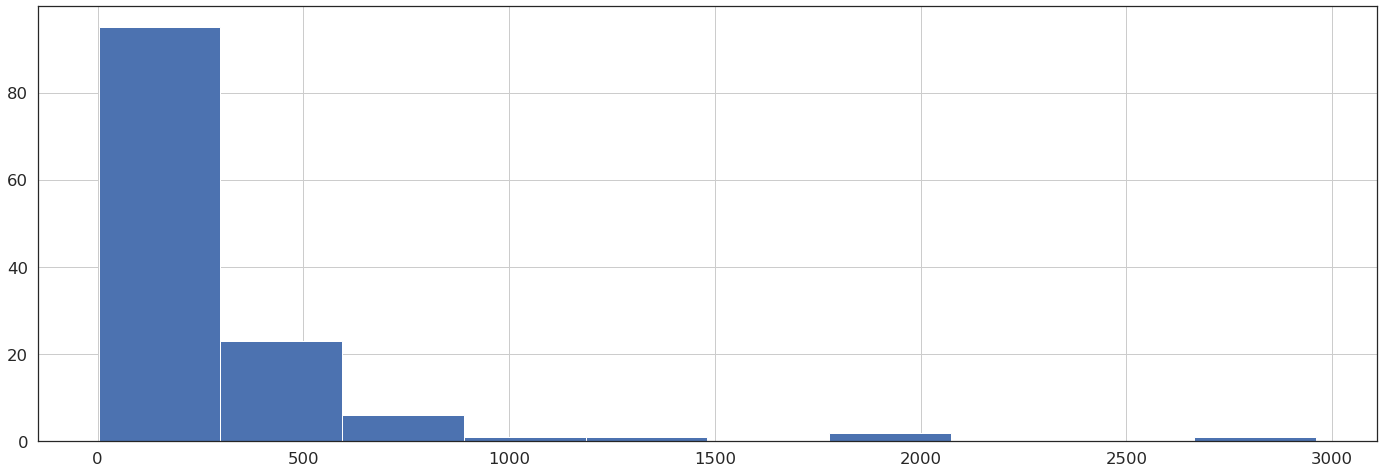

In [77]:
anno['TM_CD8_Density'].hist()

In [ ]:
ann

In [84]:
fts = merge_nonoverlapping(feature_subset, anno).dropna(subset=['TC_CD8_Density','all_nodes_area_weighted'])

In [122]:
qq_df = get_qq(fts, 'TC_CD8_Density','all_nodes_area_weighted')

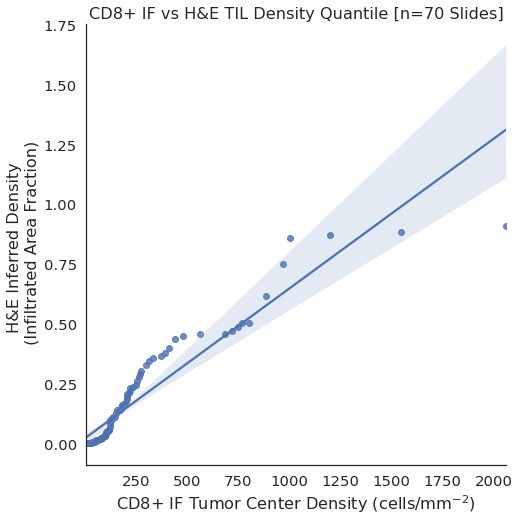

In [128]:
set_rc(8,8, 1.35)
sns.lmplot(x='TC_CD8_Density_quantiles',y='all_nodes_area_weighted_quantiles', data=qq_df, height=7)
plt.ylabel('H&E Inferred Density \n (Infiltrated Area Fraction)')
plt.xlabel('CD8+ IF Tumor Center Density (cells/mm$^{-2}$)')
plt.title('CD8+ IF vs H&E TIL Density Quantile [n=70 Slides]')
for ext in ['pdf','png']:
    plt.savefig(f'./sweep_outputs/qq_plot_cd8_tc_density_vs_all_nodes_area_weighted.{ext}', bbox_inches='tight')